# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

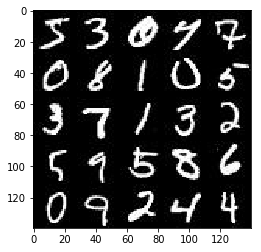

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

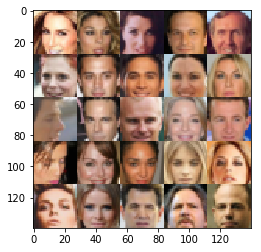

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # DONE: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "c:\\users\\peter\\anaconda3\\envs\\tflearn-gpu\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "c:\\users\\peter\\anaconda3\\envs\\tflearn-gpu\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "c:\\users\\peter\\anaconda3\\envs\\tflearn-gpu\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "c:\\users\\peter\\anaconda3\\envs\\tflearn-gpu\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "c:\\users\\peter\\anaconda3\\envs\\tflearn-gpu\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instan

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # DONE: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28 x 28 x out_channel_dim
        #print(images.get_shape().as_list())
        
        # conv to 14, 14, 128
        x = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
        # conv to 7, 7, 256
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding='same', use_bias=False)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
        # conv to 4, 4, 512
        x = tf.layers.conv2d(x, 512, 5, strides=2, padding='same', use_bias=False)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
        # flatten
        x = tf.reshape(x, (-1, 4*4*512))
        #print(x.get_shape().as_list())
        
        # logits and output
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)
        
        
        return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.02): # I put alpha parameter to this function call
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # DONE: Implement Function
    
    # auxiliar variables
    reuse = not is_train
    
    # scope for generator
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.layers.dense(z, 4*4*512)
        #print(x.get_shape().as_list())
        
        # batch normalization to 4x4x512
        x = tf.reshape(x, (-1, 4, 4, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
        
        # conv to 7x7x256
        x = tf.layers.conv2d_transpose(x, 256, 4, strides=1, padding='valid')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
            
        # conv to 14x14x128        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #print(x.get_shape().as_list())
        
        # Output layer, 28 x 28 x out_channel_dim (3 or 1, depending on the task - faces or minst)
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same')
        #print(logits.get_shape().as_list())
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
smooth = 0.1

def model_loss(input_real, input_z, out_channel_dim, alpha=0.02): # I put alpha parameter to this function call
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # DONE: Implement Function
    
    # Just for reference:
    #   discriminator(images, reuse=False, alpha=0.01)
    #   generator(z, out_channel_dim, is_train=True, alpha=0.02): # I put alpha parameter to this function call
    
    g_out = generator(input_z, out_channel_dim, alpha=alpha)
    d_out_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                        logits=d_logits_real,
                                                        labels=tf.ones_like(d_out_real) * (1. - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                        logits=d_logits_fake,
                                                        labels=tf.zeros_like(d_out_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                        logits=d_logits_fake,
                                                        labels=tf.ones_like(d_out_fake)))

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # DONE: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
from datetime import datetime

print_every = 10
show_every = 100
n_images = 16

#class GAN:
#    def __init__(self, data_shape, z_size, learning_rate, alpha=0.02, beta1=0.5):
#        tf.reset_default_graph()
#        
#        # Only for reference:
#        #   model_inputs(image_width, image_height, image_channels, z_dim) -> inputs_real, inputs_z, lr
#        #   model_loss(input_real, input_z, out_channel_dim, alpha=0.02) -> d_loss, g_loss
#        #   model_opt(d_loss, g_loss, learning_rate, beta1) -> d_train_opt, g_train_opt
#
#        self.input_real, self.input_z, self.learning_rate = model_inputs(*data_shape[1:], z_dim)
#
#        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, data_shape[-1], alpha=0.02)
#        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)


def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # DONE: Build Model
    # Create the network
    #net = GAN(data_shape, z_dim, learning_rate, beta1=beta1)
    tf.reset_default_graph()

    minput_real, minput_z, mlearning_rate = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(minput_real, minput_z, data_shape[-1], alpha=0.02)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    
    # Auxiliar variables
    steps = 0
    out_channel_dim = 3 if data_image_mode == 'RGB' else 1
    sample_z = np.random.uniform(-1, 1, size=(n_images, z_dim))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # DOING: Train Model
                steps += 1
                
                # rescale from [-.5, .5] to [-1., 1.]
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                #_ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z, net.learning_rate : learning_rate})
                #_ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.learning_rate : learning_rate, net.input_real: batch_images})
                _ = sess.run(d_opt, feed_dict={minput_real: batch_images, minput_z: batch_z, mlearning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={minput_z: batch_z, mlearning_rate: learning_rate, minput_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    #train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    #train_loss_g = net.g_loss.eval({net.input_z: batch_z})
                    train_loss_d = d_loss.eval({minput_z: batch_z, minput_real: batch_images})
                    train_loss_g = g_loss.eval({minput_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Time Stamp {}".format(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    #samples.append(gen_samples)
                    show_generator_output(sess, n_images, tf.convert_to_tensor(sample_z, dtype=tf.float32), out_channel_dim, data_image_mode)
                                

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Time Stamp 2017-07-30 21:45:07.892 Discriminator Loss: 2.8165... Generator Loss: 0.1321
Epoch 1/2... Time Stamp 2017-07-30 21:45:20.054 Discriminator Loss: 0.5796... Generator Loss: 12.2294


IndexError: list index out of range

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Time Stamp 2017-07-30 21:46:16.058 Discriminator Loss: 0.5805... Generator Loss: 2.8191
Epoch 1/1... Time Stamp 2017-07-30 21:46:45.991 Discriminator Loss: 0.7684... Generator Loss: 2.8974
Epoch 1/1... Time Stamp 2017-07-30 21:47:19.304 Discriminator Loss: 1.2086... Generator Loss: 15.7276
Epoch 1/1... Time Stamp 2017-07-30 21:47:51.843 Discriminator Loss: 0.5836... Generator Loss: 6.5096
Epoch 1/1... Time Stamp 2017-07-30 21:48:25.412 Discriminator Loss: 0.8303... Generator Loss: 3.5934
Epoch 1/1... Time Stamp 2017-07-30 21:48:56.593 Discriminator Loss: 1.3020... Generator Loss: 0.7828
Epoch 1/1... Time Stamp 2017-07-30 21:49:24.752 Discriminator Loss: 0.9473... Generator Loss: 3.8580
Epoch 1/1... Time Stamp 2017-07-30 21:49:53.802 Discriminator Loss: 1.4619... Generator Loss: 0.6203
Epoch 1/1... Time Stamp 2017-07-30 21:50:21.826 Discriminator Loss: 0.7604... Generator Loss: 1.5966
Epoch 1/1... Time Stamp 2017-07-30 21:50:47.851 Discriminator Loss: 0.5314... Generator Lo

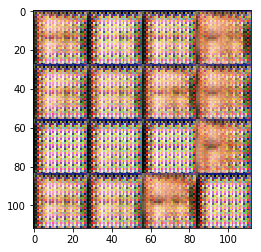

Epoch 1/1... Time Stamp 2017-07-30 21:51:16.286 Discriminator Loss: 0.7527... Generator Loss: 1.4626
Epoch 1/1... Time Stamp 2017-07-30 21:51:42.865 Discriminator Loss: 0.8315... Generator Loss: 2.7214
Epoch 1/1... Time Stamp 2017-07-30 21:52:09.324 Discriminator Loss: 1.4065... Generator Loss: 0.5690
Epoch 1/1... Time Stamp 2017-07-30 21:52:35.034 Discriminator Loss: 1.3335... Generator Loss: 0.7883
Epoch 1/1... Time Stamp 2017-07-30 21:53:01.236 Discriminator Loss: 0.9905... Generator Loss: 1.3647
Epoch 1/1... Time Stamp 2017-07-30 21:53:27.517 Discriminator Loss: 0.6345... Generator Loss: 2.2919
Epoch 1/1... Time Stamp 2017-07-30 21:53:53.696 Discriminator Loss: 0.8274... Generator Loss: 2.1041
Epoch 1/1... Time Stamp 2017-07-30 21:54:19.822 Discriminator Loss: 0.7835... Generator Loss: 1.6635
Epoch 1/1... Time Stamp 2017-07-30 21:54:45.508 Discriminator Loss: 1.0693... Generator Loss: 2.8065
Epoch 1/1... Time Stamp 2017-07-30 21:55:12.631 Discriminator Loss: 1.9528... Generator Los

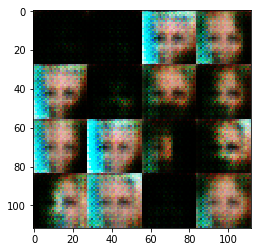

Epoch 1/1... Time Stamp 2017-07-30 21:55:41.371 Discriminator Loss: 1.0926... Generator Loss: 1.8906
Epoch 1/1... Time Stamp 2017-07-30 21:56:07.024 Discriminator Loss: 0.7821... Generator Loss: 1.3082
Epoch 1/1... Time Stamp 2017-07-30 21:56:34.139 Discriminator Loss: 0.8283... Generator Loss: 1.3458
Epoch 1/1... Time Stamp 2017-07-30 21:56:59.811 Discriminator Loss: 0.8063... Generator Loss: 1.4740
Epoch 1/1... Time Stamp 2017-07-30 21:57:26.331 Discriminator Loss: 0.9851... Generator Loss: 1.1435
Epoch 1/1... Time Stamp 2017-07-30 21:57:53.225 Discriminator Loss: 1.1610... Generator Loss: 2.5098
Epoch 1/1... Time Stamp 2017-07-30 21:58:23.035 Discriminator Loss: 1.2862... Generator Loss: 0.6587
Epoch 1/1... Time Stamp 2017-07-30 21:58:49.332 Discriminator Loss: 0.7926... Generator Loss: 2.0198
Epoch 1/1... Time Stamp 2017-07-30 21:59:15.025 Discriminator Loss: 0.7966... Generator Loss: 2.0900
Epoch 1/1... Time Stamp 2017-07-30 21:59:41.459 Discriminator Loss: 0.7850... Generator Los

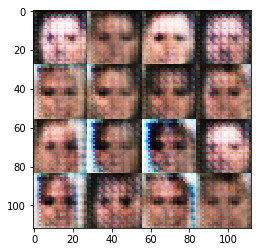

Epoch 1/1... Time Stamp 2017-07-30 22:00:09.156 Discriminator Loss: 0.9133... Generator Loss: 2.8572
Epoch 1/1... Time Stamp 2017-07-30 22:00:35.781 Discriminator Loss: 0.7343... Generator Loss: 1.8728
Epoch 1/1... Time Stamp 2017-07-30 22:01:01.772 Discriminator Loss: 2.8778... Generator Loss: 0.1660
Epoch 1/1... Time Stamp 2017-07-30 22:01:27.598 Discriminator Loss: 1.7040... Generator Loss: 0.4257
Epoch 1/1... Time Stamp 2017-07-30 22:01:54.995 Discriminator Loss: 0.7841... Generator Loss: 1.7971
Epoch 1/1... Time Stamp 2017-07-30 22:02:19.608 Discriminator Loss: 0.9461... Generator Loss: 1.2675
Epoch 1/1... Time Stamp 2017-07-30 22:02:46.315 Discriminator Loss: 0.8468... Generator Loss: 1.1906
Epoch 1/1... Time Stamp 2017-07-30 22:03:12.429 Discriminator Loss: 0.8331... Generator Loss: 1.1593
Epoch 1/1... Time Stamp 2017-07-30 22:03:37.904 Discriminator Loss: 0.8030... Generator Loss: 1.6973
Epoch 1/1... Time Stamp 2017-07-30 22:04:04.278 Discriminator Loss: 0.7236... Generator Los

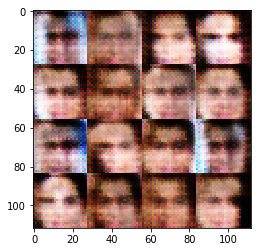

Epoch 1/1... Time Stamp 2017-07-30 22:04:30.389 Discriminator Loss: 1.3916... Generator Loss: 0.7726
Epoch 1/1... Time Stamp 2017-07-30 22:04:56.754 Discriminator Loss: 0.8418... Generator Loss: 1.1570
Epoch 1/1... Time Stamp 2017-07-30 22:05:22.722 Discriminator Loss: 0.9057... Generator Loss: 4.0095
Epoch 1/1... Time Stamp 2017-07-30 22:05:49.450 Discriminator Loss: 0.9219... Generator Loss: 3.2327
Epoch 1/1... Time Stamp 2017-07-30 22:06:16.806 Discriminator Loss: 1.1068... Generator Loss: 0.9448
Epoch 1/1... Time Stamp 2017-07-30 22:06:43.887 Discriminator Loss: 0.6570... Generator Loss: 1.7023
Epoch 1/1... Time Stamp 2017-07-30 22:07:10.324 Discriminator Loss: 0.4813... Generator Loss: 3.4012
Epoch 1/1... Time Stamp 2017-07-30 22:07:40.036 Discriminator Loss: 1.3651... Generator Loss: 2.2949
Epoch 1/1... Time Stamp 2017-07-30 22:08:07.875 Discriminator Loss: 0.9288... Generator Loss: 1.2993
Epoch 1/1... Time Stamp 2017-07-30 22:08:36.934 Discriminator Loss: 0.6371... Generator Los

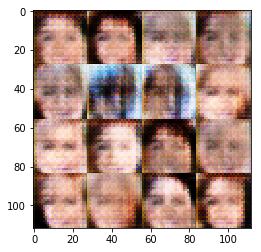

Epoch 1/1... Time Stamp 2017-07-30 22:09:05.093 Discriminator Loss: 1.1972... Generator Loss: 1.2169
Epoch 1/1... Time Stamp 2017-07-30 22:09:31.515 Discriminator Loss: 1.1641... Generator Loss: 3.0120
Epoch 1/1... Time Stamp 2017-07-30 22:09:57.116 Discriminator Loss: 0.5525... Generator Loss: 2.1279
Epoch 1/1... Time Stamp 2017-07-30 22:10:22.772 Discriminator Loss: 1.1383... Generator Loss: 0.6980
Epoch 1/1... Time Stamp 2017-07-30 22:10:49.326 Discriminator Loss: 1.9232... Generator Loss: 3.8207
Epoch 1/1... Time Stamp 2017-07-30 22:11:15.981 Discriminator Loss: 1.0143... Generator Loss: 1.7008
Epoch 1/1... Time Stamp 2017-07-30 22:11:41.988 Discriminator Loss: 1.0758... Generator Loss: 1.1222
Epoch 1/1... Time Stamp 2017-07-30 22:12:08.808 Discriminator Loss: 1.2419... Generator Loss: 2.0489
Epoch 1/1... Time Stamp 2017-07-30 22:12:34.481 Discriminator Loss: 1.1055... Generator Loss: 1.1807
Epoch 1/1... Time Stamp 2017-07-30 22:13:01.587 Discriminator Loss: 0.9539... Generator Los

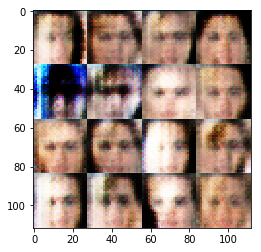

Epoch 1/1... Time Stamp 2017-07-30 22:13:28.309 Discriminator Loss: 0.7972... Generator Loss: 1.2377
Epoch 1/1... Time Stamp 2017-07-30 22:13:55.231 Discriminator Loss: 0.5436... Generator Loss: 2.0252
Epoch 1/1... Time Stamp 2017-07-30 22:14:22.303 Discriminator Loss: 0.8333... Generator Loss: 1.1792
Epoch 1/1... Time Stamp 2017-07-30 22:14:47.681 Discriminator Loss: 0.9521... Generator Loss: 1.0601
Epoch 1/1... Time Stamp 2017-07-30 22:15:13.889 Discriminator Loss: 0.8995... Generator Loss: 1.7055
Epoch 1/1... Time Stamp 2017-07-30 22:15:40.457 Discriminator Loss: 0.9688... Generator Loss: 2.6743
Epoch 1/1... Time Stamp 2017-07-30 22:16:07.505 Discriminator Loss: 0.9002... Generator Loss: 2.5142
Epoch 1/1... Time Stamp 2017-07-30 22:16:35.964 Discriminator Loss: 1.1037... Generator Loss: 1.8886
Epoch 1/1... Time Stamp 2017-07-30 22:17:01.473 Discriminator Loss: 0.9048... Generator Loss: 1.7673
Epoch 1/1... Time Stamp 2017-07-30 22:17:28.407 Discriminator Loss: 0.7350... Generator Los

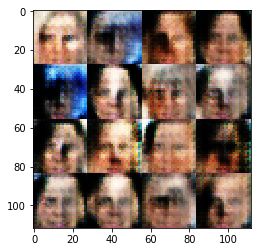

Epoch 1/1... Time Stamp 2017-07-30 22:17:54.836 Discriminator Loss: 0.5598... Generator Loss: 3.8742
Epoch 1/1... Time Stamp 2017-07-30 22:18:20.611 Discriminator Loss: 0.6346... Generator Loss: 2.4295
Epoch 1/1... Time Stamp 2017-07-30 22:18:46.015 Discriminator Loss: 2.7744... Generator Loss: 4.0216
Epoch 1/1... Time Stamp 2017-07-30 22:19:13.839 Discriminator Loss: 0.9966... Generator Loss: 1.0125
Epoch 1/1... Time Stamp 2017-07-30 22:19:40.054 Discriminator Loss: 0.9009... Generator Loss: 1.6970
Epoch 1/1... Time Stamp 2017-07-30 22:20:05.658 Discriminator Loss: 1.8336... Generator Loss: 0.4204
Epoch 1/1... Time Stamp 2017-07-30 22:20:31.840 Discriminator Loss: 0.9140... Generator Loss: 1.1247
Epoch 1/1... Time Stamp 2017-07-30 22:20:58.530 Discriminator Loss: 0.9378... Generator Loss: 1.2292
Epoch 1/1... Time Stamp 2017-07-30 22:21:24.147 Discriminator Loss: 0.5696... Generator Loss: 3.2360
Epoch 1/1... Time Stamp 2017-07-30 22:21:49.549 Discriminator Loss: 0.7510... Generator Los

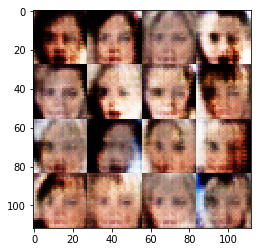

Epoch 1/1... Time Stamp 2017-07-30 22:22:16.546 Discriminator Loss: 0.6723... Generator Loss: 1.7680
Epoch 1/1... Time Stamp 2017-07-30 22:22:42.771 Discriminator Loss: 0.8761... Generator Loss: 2.3749
Epoch 1/1... Time Stamp 2017-07-30 22:23:08.650 Discriminator Loss: 1.2419... Generator Loss: 0.8356
Epoch 1/1... Time Stamp 2017-07-30 22:23:35.906 Discriminator Loss: 0.7145... Generator Loss: 1.5949
Epoch 1/1... Time Stamp 2017-07-30 22:24:01.616 Discriminator Loss: 0.8852... Generator Loss: 2.0853
Epoch 1/1... Time Stamp 2017-07-30 22:24:27.844 Discriminator Loss: 0.6014... Generator Loss: 1.8008
Epoch 1/1... Time Stamp 2017-07-30 22:24:54.344 Discriminator Loss: 0.7553... Generator Loss: 1.6347
Epoch 1/1... Time Stamp 2017-07-30 22:25:19.815 Discriminator Loss: 1.0469... Generator Loss: 0.9409
Epoch 1/1... Time Stamp 2017-07-30 22:25:45.346 Discriminator Loss: 1.5036... Generator Loss: 0.4675
Epoch 1/1... Time Stamp 2017-07-30 22:26:10.979 Discriminator Loss: 0.8496... Generator Los

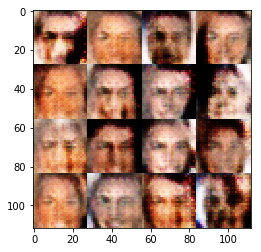

Epoch 1/1... Time Stamp 2017-07-30 22:26:37.320 Discriminator Loss: 0.7766... Generator Loss: 1.1826
Epoch 1/1... Time Stamp 2017-07-30 22:27:02.552 Discriminator Loss: 1.4206... Generator Loss: 3.7338
Epoch 1/1... Time Stamp 2017-07-30 22:27:27.423 Discriminator Loss: 0.8058... Generator Loss: 1.4281
Epoch 1/1... Time Stamp 2017-07-30 22:27:54.077 Discriminator Loss: 1.0209... Generator Loss: 0.8649
Epoch 1/1... Time Stamp 2017-07-30 22:28:19.720 Discriminator Loss: 0.7187... Generator Loss: 2.1559
Epoch 1/1... Time Stamp 2017-07-30 22:28:46.197 Discriminator Loss: 0.9923... Generator Loss: 1.1276
Epoch 1/1... Time Stamp 2017-07-30 22:29:11.461 Discriminator Loss: 0.8749... Generator Loss: 1.5615
Epoch 1/1... Time Stamp 2017-07-30 22:29:37.393 Discriminator Loss: 0.7798... Generator Loss: 1.2242
Epoch 1/1... Time Stamp 2017-07-30 22:30:03.629 Discriminator Loss: 1.0538... Generator Loss: 1.3165
Epoch 1/1... Time Stamp 2017-07-30 22:30:32.252 Discriminator Loss: 0.9502... Generator Los

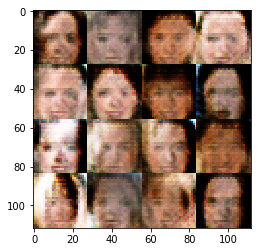

Epoch 1/1... Time Stamp 2017-07-30 22:30:58.609 Discriminator Loss: 0.7305... Generator Loss: 1.8481
Epoch 1/1... Time Stamp 2017-07-30 22:31:26.451 Discriminator Loss: 0.5319... Generator Loss: 3.0499


IndexError: list index out of range

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.